## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
MouseMerge= pd.merge(mouse_metadata, study_results, on="Mouse ID", how="outer")
# Display the data table for preview
MouseMerge

#MouseOutput = MouseMerge.to_csv("MouseMerge.csv", index=False)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [2]:
# Checking the number of mice.
Mice = MouseMerge["Mouse ID"].nunique()
print("There are " + str(Mice) + " total mice enrolled in the study.")

There are 249 total mice enrolled in the study.


In [3]:
# # Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

# ID = MouseMerge["Mouse ID"]
MouseMerge['Dupe'] = MouseMerge.duplicated(subset = ["Mouse ID", "Timepoint"],keep=False)
Dupes = MouseMerge.loc[MouseMerge['Dupe'] == True]

# Group them Up
DupeMice = Dupes.groupby(["Mouse ID"]).count()
DupeMice

,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Dupe
Mouse ID,,,,,,,,
g989,10,10,10,10,10,10,10,10


In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
BadMouse = MouseMerge.loc[MouseMerge['Mouse ID'] == "g989"]
BadMouse

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Dupe
908,g989,Propriva,Female,21,26,0,45.000000,0,True
909,g989,Propriva,Female,21,26,0,45.000000,0,True
910,g989,Propriva,Female,21,26,5,48.786801,0,True
911,g989,Propriva,Female,21,26,5,47.570392,0,True
912,g989,Propriva,Female,21,26,10,51.745156,0,True
913,g989,Propriva,Female,21,26,10,49.880528,0,True
914,g989,Propriva,Female,21,26,15,51.325852,1,True
915,g989,Propriva,Female,21,26,15,53.442020,0,True
916,g989,Propriva,Female,21,26,20,55.326122,1,True
917,g989,Propriva,Female,21,26,20,54.657650,1,True


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
MiceIndices = MouseMerge[MouseMerge["Mouse ID"] == "g989"].index
MiceIndices

# Don't hose up the base data
CleanMice = MouseMerge.copy()
CleanMice.drop(MiceIndices, inplace = True)

CleanMice

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Dupe
0,k403,Ramicane,Male,21,16,0,45.000000,0,False
1,k403,Ramicane,Male,21,16,5,38.825898,0,False
2,k403,Ramicane,Male,21,16,10,35.014271,1,False
3,k403,Ramicane,Male,21,16,15,34.223992,1,False
4,k403,Ramicane,Male,21,16,20,32.997729,1,False
...,...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2,False
1889,z969,Naftisol,Male,9,30,30,65.841013,3,False
1890,z969,Naftisol,Male,9,30,35,69.176246,4,False
1891,z969,Naftisol,Male,9,30,40,70.314904,4,False


In [6]:
# Checking the number of mice in the clean DataFrame.
Clean = CleanMice["Mouse ID"].nunique()
Bad = BadMouse["Mouse ID"].nunique ()

print("There are " + str(Clean) + " mice left in the study after " + str(Bad) + " mouse was removed.")

There are 248 mice left in the study after 1 mouse was removed.


## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.
Summary = pd.DataFrame(round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].mean(),2))
Summary.rename(columns={"Tumor Volume (mm3)":"Mean"}, inplace=True)

# Median
SumMed = round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].median(),2)
Summary["Median"] = SumMed

# Variance
SumVar = round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].var(),2)
Summary["Var"] = SumVar

# Standard Deviation
SumSTD = round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].std(),2)
Summary["STD"] = SumSTD

# SEM
SumSEM = round(CleanMice.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].sem(),2)
Summary["SEM"] = SumSEM

Summary

,Mean,Median,Var,STD,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.45,43.85,6.62,0.54
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
ShortSum = round(CleanMice.groupby(['Drug Regimen']).agg({"Tumor Volume (mm3)":['mean', "median", "var", "std","sem"]}),2)

ShortSum                                                      

Tumor Volume (mm3)                          
                           mean median    var   std   sem
Drug Regimen                                             
Capomulin                 40.68  41.56  24.95  4.99  0.33
Ceftamin                  52.59  51.78  39.29  6.27  0.47
Infubinol                 52.88  51.82  43.13  6.57  0.49
Ketapril                  55.24  53.70  68.55  8.28  0.60
Naftisol                  54.33  52.51  66.17  8.13  0.60
Placebo                   54.03  52.29  61.17  7.82  0.58
Propriva                  52.32  50.45  43.85  6.62  0.54
Ramicane                  40.22  40.67  23.49  4.85  0.32
Stelasyn                  54.23  52.43  59.45  7.71  0.57
Zoniferol                 53.24  51.82  48.53  6.97  0.52

## Bar and Pie Charts

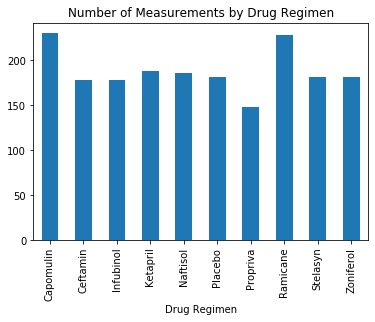

In [9]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
MeasurementCount = CleanMice.groupby(["Drug Regimen"]).count()

# Get Rid of Extra Stuff
MeasurementCount.drop(["Sex", "Age_months", "Weight (g)", "Timepoint", "Tumor Volume (mm3)", "Metastatic Sites", "Dupe"],axis = 1, inplace = True)
MeasurementCount.plot(kind="bar", title = "Number of Measurements by Drug Regimen", legend = False)


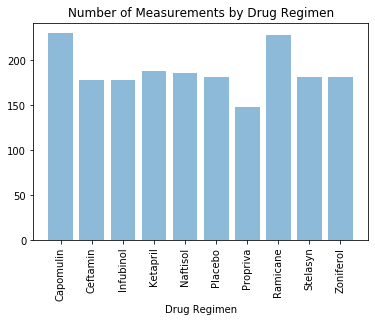

In [36]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
x_axis = np.arange(len(MeasurementCount))
plt.bar(x_axis, MeasurementCount["Mouse ID"], alpha=0.5, align="edge")
plt.xticks(tick_locations, MeasurementCount.index, rotation="vertical")
plt.title("Number of Measurements by Drug Regimen")
plt.xlabel("Drug Regimen")
plt.show()

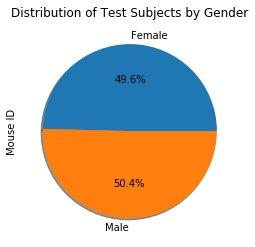

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
MetadataIndices = mouse_metadata[mouse_metadata["Mouse ID"] == "g989"].index

# Don't Mess With the Original
CleanMetadata = mouse_metadata.copy()
CleanMetadata.drop(MetadataIndices, inplace = True)
MetaGroup = CleanMetadata.groupby(["Sex"]).count()
MetaGroup
MetaGroup.plot(kind = "pie", y = "Mouse ID", legend = False, title = "Distribution of Test Subjects by Gender", shadow = True, autopct = "%1.1f%%")

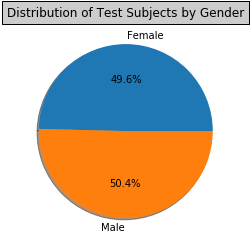

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(MetaGroup["Mouse ID"], autopct = "%1.1f%%", labels = MetaGroup.index , shadow = True)
plt.title("Distribution of Test Subjects by Gender", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
SelectMice = CleanMice[CleanMice['Drug Regimen'].isin(['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin'])]
SelectMice

# Start by getting the last (greatest) timepoint for each mouse
LastTime = pd.DataFrame(SelectMice.groupby(["Mouse ID"])["Timepoint"].max())
LastTime

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
LastSize= pd.merge(LastTime, SelectMice, on=["Mouse ID", "Timepoint"], how="left")
LastSize

,Mouse ID,Timepoint,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3),Metastatic Sites,Dupe
0,a203,45,Infubinol,Female,20,23,67.973419,2,False
1,a251,45,Infubinol,Female,21,25,65.525743,1,False
2,a275,45,Ceftamin,Female,20,28,62.999356,3,False
3,a411,45,Ramicane,Male,3,22,38.407618,1,False
4,a444,45,Ramicane,Female,10,25,43.047543,0,False
...,...,...,...,...,...,...,...,...,...
95,y769,45,Ceftamin,Female,6,27,68.594745,4,False
96,y793,45,Capomulin,Male,17,17,31.896238,2,False
97,y865,45,Ceftamin,Male,23,26,64.729837,3,False
98,z578,45,Ramicane,Male,11,16,30.638696,0,False


In [14]:
# Put treatments into a list for for loop (and later for plot labels)
Meds = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
TumVolCap = []
TumVolRam = []
TumVolInf = []
TumVolCef = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

# Locate the rows which contain mice on each drug and get the tumor volumes

for index, row in LastSize.iterrows():
    if LastSize.loc[index,"Drug Regimen"] == "Capomulin":
        TumVolCap.append(LastSize.loc[index,"Tumor Volume (mm3)"])
    elif LastSize.loc[index,"Drug Regimen"] == "Ramicane":
        TumVolRam.append(LastSize.loc[index,"Tumor Volume (mm3)"])
    elif LastSize.loc[index,"Drug Regimen"] == "Infubinol":
        TumVolInf.append(LastSize.loc[index,"Tumor Volume (mm3)"])
    elif LastSize.loc[index,"Drug Regimen"] == "Ceftamin":
        TumVolCef.append(LastSize.loc[index,"Tumor Volume (mm3)"])



In [30]:
# Calculate the IQR
TumVolCap.sort()
CapQ1 = np.percentile(TumVolCap, [25])
CapQ2 = np.percentile(TumVolCap, [50])
CapQ3 = np.percentile(TumVolCap, [75])
CapIQR = CapQ3 - CapQ1

RamQ1 = np.percentile(TumVolRam, [25])
RamQ2 = np.percentile(TumVolRam, [50])
RamQ3 = np.percentile(TumVolRam, [75])
RamIQR = RamQ3 - RamQ1

InfQ1 = np.percentile(TumVolInf, [25])
InfQ2 = np.percentile(TumVolInf, [50])
InfQ3 = np.percentile(TumVolInf, [75])
InfIQR = InfQ3 - InfQ1

CefQ1 = np.percentile(TumVolCef, [25])
CefQ2 = np.percentile(TumVolCef, [50])
CefQ3 = np.percentile(TumVolCef, [75])
CefIQR = CefQ3 - CefQ1


print(f'Capomulin has quartiles at {CapQ1}, {CapQ2}, {CapQ3} and an IQR of {CapIQR})')
print(f'Ramicane has quartiles at {RamQ1}, {RamQ2}, {RamQ3} and an IQR of {RamIQR})')
print(f'Infubinol has quartiles at {InfQ1}, {InfQ2}, {InfQ3} and an IQR of {InfIQR})')
print(f'Ceftamin has quartiles at {CefQ1}, {CefQ2}, {CefQ3} and an IQR of {CefIQR})')

Capomulin has quartiles at [32.37735684], [38.1251644], [40.1592203] and an IQR of [7.78186346])
Ramicane has quartiles at [31.56046955], [36.56165229], [40.65900627] and an IQR of [9.09853672])
Infubinol has quartiles at [54.04860769], [60.16518046], [65.52574285] and an IQR of [11.47713516])
Ceftamin has quartiles at [48.72207785], [59.85195552], [64.29983003] and an IQR of [15.57775218])


In [16]:
# Quantitatively determine if there are any potential outliers. 
CapOutlier = []
RamOutlier = []
InfOutlier = []
CefOutlier = []

for index, row in LastSize.iterrows():
    if LastSize.loc[index,"Drug Regimen"] == "Capomulin":
        if LastSize.loc[index,"Tumor Volume (mm3)"] < CapQ1:
            CapOutlier.append(LastSize.loc[index,"Tumor Volume (mm3)"])
        elif LastSize.loc[index,"Tumor Volume (mm3)"] > CapQ3:
            CapOutlier.append(LastSize.loc[index,"Tumor Volume (mm3)"])
   
    elif LastSize.loc[index,"Drug Regimen"] == "Ramicane":
        if LastSize.loc[index,"Tumor Volume (mm3)"] < RamQ1:
            RamOutlier.append(LastSize.loc[index,"Tumor Volume (mm3)"])
        elif LastSize.loc[index,"Tumor Volume (mm3)"] > RamQ3:
            RamOutlier.append(LastSize.loc[index,"Tumor Volume (mm3)"])
    
    elif LastSize.loc[index,"Drug Regimen"] == "Infubinol":
        if LastSize.loc[index,"Tumor Volume (mm3)"] < InfQ1:
            InfOutlier.append(LastSize.loc[index,"Tumor Volume (mm3)"])
        elif LastSize.loc[index,"Tumor Volume (mm3)"] > InfQ3:
            InfOutlier.append(LastSize.loc[index,"Tumor Volume (mm3)"])
    
    elif LastSize.loc[index,"Drug Regimen"] == "Ceftamin":
        if LastSize.loc[index,"Tumor Volume (mm3)"] < CefQ1:
            CefOutlier.append(LastSize.loc[index,"Tumor Volume (mm3)"])
        elif LastSize.loc[index,"Tumor Volume (mm3)"] > CefQ3:
            CefOutlier.append(LastSize.loc[index,"Tumor Volume (mm3)"])
    

print("Capomulin Outliers")
CapOutlier.sort()
print(CapOutlier)
print("Ramicane Outliers")
RamOutlier.sort()
print(RamOutlier)
print("Infubinol Outliers")
InfOutlier.sort()
print(InfOutlier)
print("Ceftamin Outliers")
CefOutlier.sort()
print(CefOutlier)

Capomulin Outliers
[23.34359787, 28.43096411, 28.48403281, 30.48598484, 31.02392294, 31.896238399999998, 40.65812366, 40.72857787, 41.48300765, 41.58152074, 46.53920617, 47.68596303]
Ramicane Outliers
[22.05012627, 29.12847181, 30.27623175, 30.56462509, 30.63869575, 31.09533505, 40.66771292, 43.04754260000001, 43.16637266, 43.41938077, 44.18345092, 45.22086888]
Infubinol Outliers
[36.321345799999996, 45.69933088, 46.25011212, 47.01036401, 50.00513807, 51.54243058, 66.08306589, 66.19691151, 67.28962147, 67.68556862, 67.97341878, 72.2267309]
Ceftamin Outliers
[45.0, 45.0, 45.0, 45.0, 46.78453491, 47.784681799999994, 64.63494887, 64.72983655, 67.52748237, 67.74866174, 68.59474498, 68.92318457]


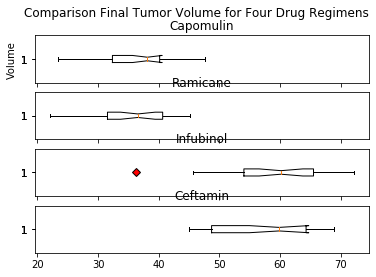

In [35]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig, axs = plt.subplots(4, sharex=True, sharey=True,)

# Set up Outlier Markers
red_diamond = dict(markerfacecolor='r', marker='D')

# Add Titles
fig.suptitle('Comparison Final Tumor Volume for Four Drug Regimens')

# Cap
axs[0].boxplot(TumVolCap, vert = False, notch = True, flierprops = red_diamond)
axs[0].set_title('Capomulin')

# Ram
axs[1].boxplot(TumVolRam, vert = False, notch = True, flierprops = red_diamond)
axs[1].set_title('Ramicane')

# Inf
axs[2].boxplot(TumVolInf, vert = False, notch = True, flierprops = red_diamond)
axs[2].set_title('Infubinol')

# Cef
axs[3].boxplot(TumVolCef, vert = False, notch = True, flierprops = red_diamond)
axs[3].set_title('Ceftamin')
axs[0].set_ylabel('Volume')

plt.show()

## Line and Scatter Plots

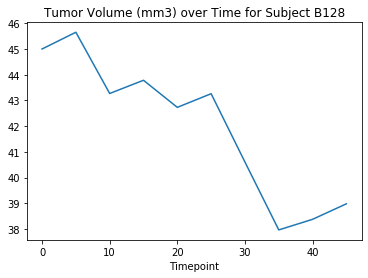

In [18]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
CapMice = CleanMice[CleanMice['Drug Regimen'].isin(['Capomulin'])]

#Select first mouse, b128

B128 = CleanMice[CleanMice['Mouse ID'].isin(['b128'])]


B128.plot.line(x="Timepoint", y="Tumor Volume (mm3)", title="Tumor Volume (mm3) over Time for Subject B128", legend = False);

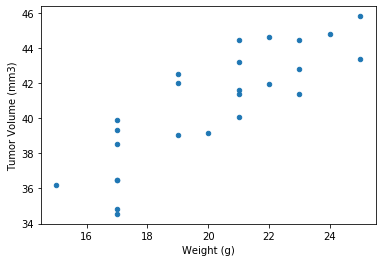

In [19]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
CapMiceAve = CapMice.groupby(["Mouse ID"]).mean()
CapMiceAve

CapMiceAve.plot.scatter(x = "Weight (g)", y = "Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

The correlation between weight and tumor volume is 0.84
The r-squared is: 0.71


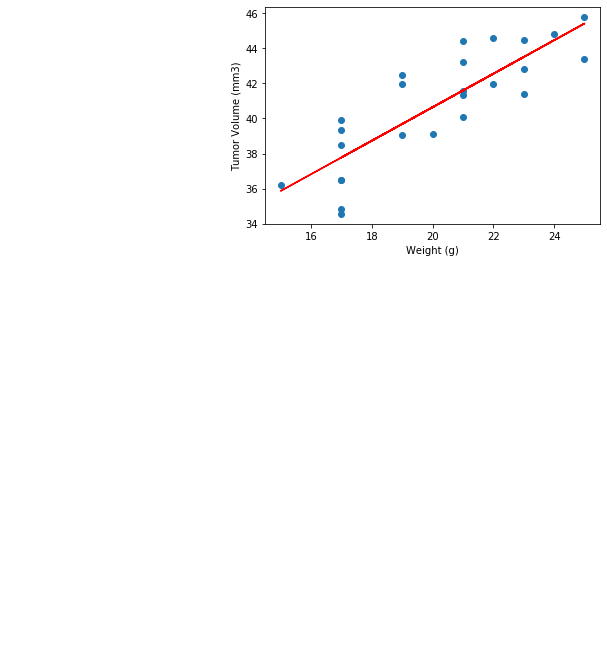

In [27]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

correlation = st.pearsonr(CapMiceAve["Weight (g)"],CapMiceAve["Tumor Volume (mm3)"])
print(f"The correlation between weight and tumor volume is {round(correlation[0],2)}")

x_values = CapMiceAve['Weight (g)']
y_values = CapMiceAve['Tumor Volume (mm3)']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
print(f"The r-squared is: {round(rvalue**2,2)}")
plt.show()